In [2]:
import torch, torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generating the dataset
This part of the notebook is encoded in `generate_dataset.py` and served as a exploration notebook. 

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [4]:
train_loader = DataLoader(mnist_trainset, batch_size=len(mnist_trainset))
test_loader = DataLoader(mnist_testset, batch_size=len(mnist_testset))

In [5]:
next(iter(test_loader))[0].numpy().shape

(10000, 1, 28, 28)

In [6]:
train_dataset_array = next(iter(train_loader))[1].numpy()

In [7]:
x_train = next(iter(train_loader))[0].numpy()
y_train = next(iter(train_loader))[1].numpy()
x_test = next(iter(test_loader))[0].numpy()
y_test = next(iter(test_loader))[1].numpy()

In [8]:
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)

# Get the generator

In [9]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

In [10]:
# build network
z_dim = 100
mnist_dim = mnist_trainset.train_data.size(1) * mnist_trainset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)

/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [11]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [12]:
x_real = next(iter(train_loader))[0].numpy()[:1000]

In [13]:
len(x_real)

1000

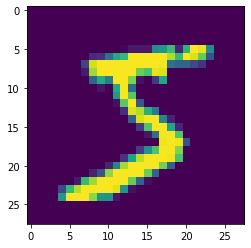

In [14]:
import matplotlib.pyplot as plt
plt.imshow(x_real[0][0])
plt.show()

In [15]:
PATH = "generator_model_test"
G = Generator(g_input_dim = 100, g_output_dim = 784).to(device)
G.load_state_dict(torch.load(PATH))
G.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [16]:
bs = 1

x_fake = []

for i in range(1000):
    # Can we make the batch size bigger?
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_f = G(z).detach().numpy().reshape(1,28,28)
    x_fake.append(x_f)
    
x_fake = np.array(x_fake)

In [17]:
x_fake.shape

(1000, 1, 28, 28)

In [18]:
x_real.shape

(1000, 1, 28, 28)

In [41]:
x_train = np.stack((x_fake,x_real), axis=2)

In [42]:
x_train[0].shape

(1, 2, 28, 28)

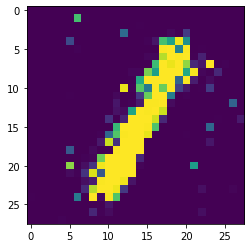

In [46]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0][0][0])
plt.show()

In [108]:
# np.save("x_real", x_real)
np.save("x_fake", x_fake)

In [109]:
x_fake[0].reshape(1,784).shape

(1, 784)

In [110]:
x_fake[1].shape

(1, 28, 28)

# Creating Inference Dataset
The following is an exploratory notebook used in the file ``

In [56]:
import json

In [58]:
json_str = json.dumps(x_fake.tolist())

In [63]:
type(json_str)

str

In [64]:
with open("inference.json", "w") as f:
    f.write(json_str)